In [46]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import torch
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

# Util function for loading meshes
from pytorch3d.io import load_obj
from PIL import Image, ImageDraw

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    BlendParams,
    DirectionalLights, 
    Materials, 
    SoftPhongShader,
    HardPhongShader,
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

print('python:', sys.version)
print('torch :', torch.__version__)
print('cuda  :', torch.version.cuda)
%load_ext autoreload
%autoreload 2

import sys, os
os.path.dirname(sys.executable)

python: 3.8.2 (default, Apr 14 2020, 19:01:40) [MSC v.1916 64 bit (AMD64)]
torch : 1.4.0
cuda  : 10.1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'C:\\Users\\hjoon\\AppData\\Local\\Continuum\\anaconda3\\envs\\pytorch3d0'

In [13]:
device = torch.device("cuda:0")
torch.cuda.set_device(device)

verts, faces_idx, _ = load_obj("./2_data/squares.obj")
faces = faces_idx.verts_idx

verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = Textures(verts_rgb=verts_rgb.to(device))

mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

In [63]:
%matplotlib inline
images = []

cameras = OpenGLPerspectiveCameras(device=device)

sigmas = list([1e-4])
for i, sigma in enumerate(sigmas):
    print(' {}/{}'.format(i+1, len(sigmas)), end='')
    if i > 0 and i % 10 == 0:
        print()
    blend_params = BlendParams(sigma=sigma, gamma=1e-4)

    raster_settings = RasterizationSettings(
        image_size=256, 
        blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
        faces_per_pixel=1, 
    )

    silhouette_renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_settings
        ),
        shader=SoftSilhouetteShader(blend_params=blend_params)
    )

    lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
    phong_renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_settings
        ),
        shader=HardPhongShader(device=device, lights=lights)
    )
    # Select the viewpoint using spherical angles  
    distance = 3   # distance from camera to the object
    elevation = 0.0   # angle of elevation in degrees
    azimuth = 90.0  # No rotation so the camera is positioned on the +Z axis. 

    # Get the position of the camera based on the spherical angles
    R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

    # Render the teapot providing the values of R and T. 
    silhouete = silhouette_renderer(meshes_world=teapot_mesh, R=R, T=T)
    image_ref = phong_renderer(meshes_world=teapot_mesh, R=R, T=T)

    silhouete = silhouete.cpu().numpy()
    image_ref = image_ref.cpu().numpy()

    plt.figure(figsize=(7, 3))
    plt.subplot(1, 2, 1)
    plt.title('sigma={}'.format(sigma))
    plt.imshow(silhouete.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
    plt.grid(False)
    plt.subplot(1, 2, 2)
    plt.imshow(image_ref.squeeze())
    out_path = './2_data/output/plot.png'
    plt.savefig(out_path)
    plt.close('all')

    img = Image.open(out_path)
    images.append(img)

images[0].save('./2_data/output/plots.gif', save_all=True, append_images=images[1:], optimize=False, duration=300, loop=0)

 1/1

<IPython.core.display.Javascript object>


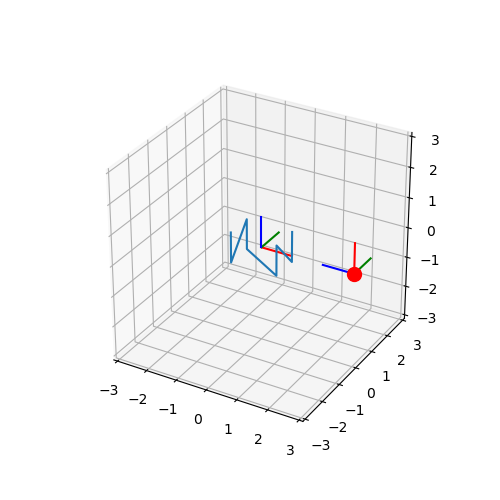

In [37]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
L = 1
ax.plot([0, L], [0, 0], [0, 0], 'r')
ax.plot([0, 0], [0, L], [0, 0], 'g')
ax.plot([0, 0], [0, 0], [0, L], 'b')

# camera 
cam_pos = cameras.get_camera_center()
cam_pos = cam_pos.squeeze().cpu().numpy()
ax.scatter(cam_pos[0], cam_pos[1], cam_pos[2], s=100, c='r')
E = cameras.get_world_to_view_transform().get_matrix()
E = E.squeeze().cpu().numpy()
Rext = E[0:3, 0:3]
Xw = np.array([1, 0, 0])*L
Yw = np.array([0, 1, 0])*L
Zw = np.array([0, 0, 1])*L
Rcam = Rext.T
Xc_w = Xw.dot(Rcam)
Yc_w = Yw.dot(Rcam)
Zc_w = Zw.dot(Rcam)
ax.plot([cam_pos[0], cam_pos[0] + Xc_w[0]], [cam_pos[1], cam_pos[1] + Xc_w[1]], [cam_pos[2], cam_pos[2] + Xc_w[2]], 'r')
ax.plot([cam_pos[0], cam_pos[0] + Yc_w[0]], [cam_pos[1], cam_pos[1] + Yc_w[1]], [cam_pos[2], cam_pos[2] + Yc_w[2]], 'g')
ax.plot([cam_pos[0], cam_pos[0] + Zc_w[0]], [cam_pos[1], cam_pos[1] + Zc_w[1]], [cam_pos[2], cam_pos[2] + Zc_w[2]], 'b')
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])
ax.set_zlim([-3, 3])
# mesh
vs = mesh.verts_packed().squeeze().cpu().numpy()
ax.plot(vs[:, 0], vs[:, 1], vs[:, 2])

<IPython.core.display.Javascript object>


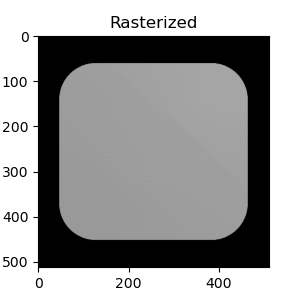

<IPython.core.display.Javascript object>


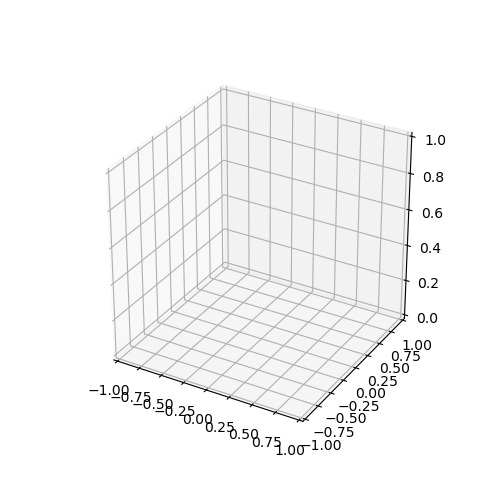

In [5]:
x_mins = np.array([-0.6692308187484741,-0.6692308187484741,-0.48823538422584534,-0.48823538422584534,])
x_maxs = np.array([0.8692307472229004,0.8692307472229004,0.6882352828979492,0.6882352828979492,])
y_mins = np.array([-0.5923076272010803,-0.5923076272010803,-0.42941179871559143,-0.42941176891326904,])
y_maxs = np.array([0.7923076748847961,0.7923076748847961,0.6294117569923401,0.6294117569923401,])
fs = np.array([[-0.67, -0.59], [-0.67, 0.79], [0.87, 0.79], [-0.67, -0.59], [0.87, 0.79], [0.87, -0.59], [-0.49, 0.63], [-0.49, -0.43], [0.69, -0.43], [-0.49, 0.63], [0.69, -0.43], [0.69, 0.63], ])
%matplotlib notebook
plt.figure(figsize=(3, 3))
plt.imshow(image.squeeze().cpu().numpy())
plt.title('Rasterized')
plt.show()

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
# plt.scatter(x_mins, y_mins, c='r', linewidth=10)
# plt.scatter(x_maxs, y_maxs, c='b', linewidth=10)
# plt.plot(fs[:,0], fs[:, 1])
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])



# plt.gca().invert_yaxis()
plt.show()

In [ ]:
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
)

silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)
image = silhouette_renderer(meshes_world=mesh)
image = image.squeeze().cpu().numpy()
plt.figure()
plt.imshow(image, vmin=0, vmax=1.0)
plt.show()

In [ ]:
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.1, 
    faces_per_pixel=1, 
)

kwargs = raster_settings
fragments = renderer.rasterizer(mesh, raster_settings=raster_settings, cameras=cameras)
fragments2, kwargs2 = renderer(mesh)

shader=HardPhongShader(device=device, lights=lights)
image = shader(fragments, mesh, kwargs)
image2 = shader(fragments2, mesh, kwargs2)
print('fragments:')
print('  pix_to_face:', fragments.pix_to_face.shape)
print('  zbuf:', fragments.zbuf.shape)
print('  bary_coords:', fragments.bary_coords.shape)
print('  dists:', fragments.dists.shape)

pix_to_face = fragments.pix_to_face.squeeze().cpu().numpy()
zbuf = fragments.zbuf.squeeze().cpu().numpy()
bary_coords = fragments.bary_coords.squeeze().cpu().numpy()
dists = fragments.dists.squeeze().cpu().numpy()

#
#
#
#
#
bary_coords = fragments.bary_coords.squeeze().cpu().numpy()
zbuf = fragments.zbuf.squeeze().cpu().numpy()
dists = fragments.dists.squeeze().cpu().numpy()
mins = np.min(np.min(bary_coords, axis=0), axis=0)
maxs = np.max(np.max(bary_coords, axis=0), axis=0)
print('----- before clipping')
print('bary_coords: {}, {}'.format(mins, maxs))
print('zbuf: {}, {}'.format(np.min(zbuf), np.max(zbuf)))
print('dists: {}, {}'.format(np.min(dists), np.max(dists)))
# print('dists: {}, {}'.format(np.))

bary_coords2 = fragments2.bary_coords.squeeze().cpu().numpy()
zbuf2 = fragments2.zbuf.squeeze().cpu().numpy()
dists2 = fragments2.dists.squeeze().cpu().numpy()
mins2 = np.min(np.min(bary_coords2, axis=0), axis=0)
maxs2 = np.max(np.max(bary_coords2, axis=0), axis=0)
print('----- after clipping')
print('bary_coords: {}, {}'.format(mins2, maxs2))
print('zbuf: {}, {}'.format(np.min(zbuf2), np.max(zbuf2)))
print('dists: {}, {}'.format(np.min(dists2), np.max(dists2)))

image = image.squeeze().cpu().numpy()
image2 = image2.squeeze().cpu().numpy()
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[0].set_title('before clipping on fragments')

ax[1].imshow(image2)
ax[1].set_title('after clipping on fragments')
plt.show()

In [ ]:
plt.figure()
plt.imshow(fragments.squeeze().cpu().numpy())
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].set_title('pix_to_face\nmin={:.2f}, max={:.2f}'.format(np.min(pix_to_face), np.max(pix_to_face)))
ax[0].imshow(pix_to_face, cmap='gray', vmin=np.min(pix_to_face), vmax=np.max(pix_to_face))

ax[1].set_title('zbuf\nmin={:.2f}, max={:.2f}'.format(np.min(zbuf), np.max(zbuf)))
ax[1].imshow(zbuf, cmap='gray', vmin=np.min(zbuf), vmax=np.max(zbuf))

ax[2].set_title('bary_coaords')
ax[2].imshow(bary_coords)

ax[3].set_title('dists\nmin={:.2f}, max={:.2f}'.format(np.min(dists), np.max(dists)))
ax[3].imshow(dists, cmap='gray', vmin=np.min(dists), vmax=np.max(dists))
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
ax[0].imshow(bary_coords[..., 0], cmap='gray')
ax[0].set_title('x\nmin={:.2f}, max={:.2f}'.format(np.min(bary_coords[..., 0]), np.max(bary_coords[..., 0])))

ax[1].imshow(bary_coords[..., 1], cmap='gray')
ax[1].set_title('y\nmin={:.2f}, max={:.2f}'.format(np.min(bary_coords[..., 1]), np.max(bary_coords[..., 1])))

ax[2].imshow(bary_coords[..., 2], cmap='gray')
ax[2].set_title('z\nmin={:.2f}, max={:.2f}'.format(np.min(bary_coords[..., 2]), np.max(bary_coords[..., 2])))
plt.show()

In [ ]:
for r in range(bary_coords.shape[0]):
    for c in range(bary_coords.shape[1]):
        if bary_coords[r, c, 0] > 0:
            print('r={}, c={}: {}'.format(r, c, bary_coords[r, c, :]))